In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import json
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import skimage.io as io
from pycocotools.coco import COCO
from tqdm import tqdm
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import Dataset, DataLoader
import os.path
from typing import Any, Callable, List, Optional, Tuple
!pip -q install timm
import timm
import string
nltk.download('punkt')
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json
import nltk
import random
import matplotlib.pyplot as plt
from skimage import io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 9.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# download dataset
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip
!wget http://images.cocodataset.org/zips/test2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip


--2023-02-04 18:03:50--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.8.163, 52.217.131.249, 52.216.63.49, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.8.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  11.0MB/s    in 19m 26s 

2023-02-04 18:23:17 (11.1 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2023-02-04 18:23:17--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.11.68, 52.217.172.57, 52.217.102.12, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.11.68|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6

In [3]:
!unzip -q train2014.zip
!unzip -q val2014.zip
!unzip -q test2014.zip
!unzip -q annotations_trainval2014.zip
!rm -rf *.zip

In [4]:
instances_path = '/content/annotations/instances_train2014.json'
captions_path = '/content/annotations/captions_train2014.json'
coco = COCO(instances_path) 
coco_caps = COCO(captions_path)

ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=10.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


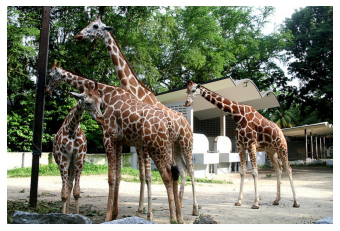

In [5]:
# sample image and caption
random_ann_id = random.choice(ids)
annotation = coco.anns[random_ann_id]
image_id = annotation['image_id']
image = coco.loadImgs(image_id)[0]
image_data = io.imread(image["coco_url"])
plt.axis("off")
plt.imshow(image_data)
plt.show()

# load and display caption annotations
caption_ann_ids = coco_caps.getAnnIds(imgIds=image_id)
caption_annotations = coco_caps.loadAnns(caption_ann_ids)
coco_caps.showAnns(caption_annotations)

In [10]:
### source : https://github.com/rammyram/image_captioning ###

class Vocab:
    def __init__(self, annotations_file, start_token, end_token, unknown_token, pad_token, threshold):
        self.start_token = start_token
        self.end_token = end_token
        self.unknown_token = unknown_token
        self.threshold = threshold
        self.pad_token = pad_token

        with open(annotations_file, 'r') as f:
            data = json.load(f)

        all_captions = [ann['caption'].lower() for ann in data['annotations']]
        words = [word for caption in all_captions for word in caption.split()]
        word_counter = Counter(words)

        self.vocab = [word for word, count in word_counter.items() if count >= self.threshold]
        self.vocab = [self.start_token, self.end_token, self.unknown_token, self.pad_token] + self.vocab
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx_to_word = {idx: word for idx, word in enumerate(self.vocab)}

    def __len__(self):
        return len(self.vocab)

    def __call__(self, word):
        return self.word_to_idx.get(word, self.word_to_idx[self.unknown_token])

    def get_word_from_idx(self, idx):
        return self.idx_to_word[idx]


class CocoDetection(VisionDataset):
    def __init__(
        self,
        root: str,
        annFile: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = [self._load_target(id)[i]['caption'] for i in range(len(self._load_target(id)))]

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self) -> int:
        return len(self.ids)

# create a CocoCaptioningDataset which takes the CocoDetection dataset as input and preprocesses the captions
class CocoCaptioningDataset(Dataset):
    def __init__(self, coco_detection_dataset, vocab, max_len=70):
        self.coco_detection_dataset = coco_detection_dataset
        self.vocab = vocab
        self.max_len = max_len

    def __getitem__(self, index):
        img, captions = self.coco_detection_dataset[index]
        # randomly select a caption
        captions = random.choice(captions)
        tokens = nltk.tokenize.word_tokenize(str(captions).lower())
        # remove punctuations 
        tokens = [word for word in tokens if word not in string.punctuation]
        caption = []
        caption.append(self.vocab(self.vocab.start_token))
        caption.extend(self.vocab(word) for word in tokens)
        caption.append(self.vocab(self.vocab.end_token))
        # pad the caption if it is less than max_len
        caption.extend([self.vocab(self.vocab.pad_token)] * (self.max_len - len(caption)))
        targets = torch.Tensor(caption).long()
        return img, targets
    def __len__(self):
        return len(self.coco_detection_dataset)
    
    def preprocess(self, caption):
        # convert all words to lowercase
        caption = [[word.lower() for word in caption.split()]]

In [20]:
class ImageEncoder(nn.Module):
    def __init__(self):
        embed_size = 256
        super(ImageEncoder, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        # freeze the weights of the pretrained model
        for param in self.resnet.parameters():
            param.requires_grad_(False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.embed_size = embed_size

    def forward(self, images):
        return self.resnet(images)

class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(CaptionDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm_layer = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc_layer = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, caption):
        # remove the last word from the caption (is code)
        caption = caption[:, :-1]
        # embed the caption 
        caption = self.embedding(caption)
        inputs = torch.cat((features.unsqueeze(1), caption), 1)
        hiddens, _ = self.lstm_layer(inputs)
        return self.fc_layer(hiddens)

    def sample_generator(self, inputs, states=None):
        max_lenght = 80
        sampled_ids = []
        for i in range(max_lenght):
            hiddens, states = self.lstm_layer(inputs, states)
            outputs = self.fc_layer(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embedding(predicted)
        return torch.stack(sampled_ids, 1)
    def vec_to_sentence(self,ids):
        caption = []
        for word_id in ids:
            word = vocab.get_word_from_idx(word_id)
            caption.append(word)
            if word == '<end>':
                break
            sentence = ' '.join(caption)
            sentence = sentence.split()
            sentence = sentence[1:-1] #delete tokens
            # # regenerate the caption
            sentence = ' '.join(sentence)
        return sentence




In [12]:
def train_and_evaluate(num_epochs, coco_captioning_dataloader, coco_captioning_val_dataloader,lr):
    embed_size = 256
    hidden_size = 512
    le_vocab = len(vocab)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss(ignore_index=vocab(vocab.pad_token))
    encoder = ImageEncoder().to(device)
    decoder = CaptionDecoder(embed_size, hidden_size, le_vocab).to(device)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    
    for epoch in range(num_epochs):
        
        encoder.train()
        decoder.train()
        for i, (images, captions) in enumerate(coco_captioning_dataloader):
            images = images.to(device)
            captions = captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions)
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(coco_captioning_dataloader), loss.item()))
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            # get a random image from the validation set
            images, captions = next(iter(coco_captioning_val_dataloader))
            images = images.to(device)
            captions = captions.to(device)
            # we have shuffle and first image will change
            image = images[0].unsqueeze(0)
            caption = captions[0].unsqueeze(0)
            # get the predicted caption
            feature = encoder(image)
            sampled_ids = decoder.sample_generator(feature)
            sampled_ids = sampled_ids[0].cpu().numpy()
            # convert the predicted caption from word ids to words
            sentence = decoder.vec_to_sentence(sampled_ids)
            
            # show the image and the predicted caption
            image = image.squeeze(0)
            image = image.permute(1, 2, 0).cpu().numpy()
            image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) #unnormalize
            image = image.clip(0,1)
            plt.imshow(image)
            print(sentence)
            plt.show()
    return encoder, decoder


    


In [13]:
# Creating dataset 
vocab = Vocab(annotations_file=captions_path, start_token='<start>', end_token='<end>', unknown_token='<unk>', pad_token='<pad>', threshold=5)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #imagenet Resnet normalizer based on 2milun images
])

batch_size = 32
coco_captioning_tr = CocoCaptioningDataset(CocoDetection(root='train2014', annFile=captions_path, transform=transform), vocab)
coco_captioning_tr_data_loader = DataLoader(coco_captioning_tr, batch_size=32, shuffle=True)

coco_captioning_valid = CocoCaptioningDataset(CocoDetection(root='val2014', annFile="annotations/captions_val2014.json", transform=transform), vocab)
coco_captioning_val_data_loader = DataLoader(coco_captioning_valid, batch_size=1, shuffle=True) #for testing in 1caption generating i have shuffle = True
print("Datasets Created successfully")

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
Datasets Created successfully


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


Epoch [1/5], Step [500/2587], Loss: 4.0538
Epoch [1/5], Step [1000/2587], Loss: 3.8348
Epoch [1/5], Step [1500/2587], Loss: 3.2003
Epoch [1/5], Step [2000/2587], Loss: 3.1053
Epoch [1/5], Step [2500/2587], Loss: 3.1850
a group of people standing in a


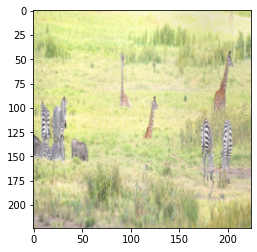

Epoch [2/5], Step [500/2587], Loss: 3.0517
Epoch [2/5], Step [1000/2587], Loss: 2.6501
Epoch [2/5], Step [1500/2587], Loss: 3.0087
Epoch [2/5], Step [2000/2587], Loss: 3.0067
Epoch [2/5], Step [2500/2587], Loss: 2.6366
a red fire hydrant sitting on a sidewalk next to a


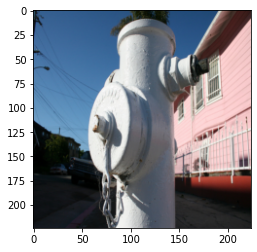

Epoch [3/5], Step [500/2587], Loss: 2.6061
Epoch [3/5], Step [1000/2587], Loss: 2.4529
Epoch [3/5], Step [1500/2587], Loss: 2.6835
Epoch [3/5], Step [2000/2587], Loss: 2.7555
Epoch [3/5], Step [2500/2587], Loss: 2.4893
a vase with flowers in it sitting on a


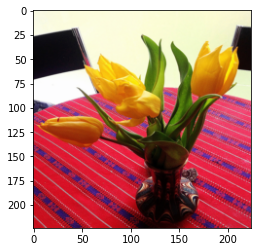

Epoch [4/5], Step [500/2587], Loss: 2.4532
Epoch [4/5], Step [1000/2587], Loss: 2.4037
Epoch [4/5], Step [1500/2587], Loss: 2.4214
Epoch [4/5], Step [2000/2587], Loss: 2.2923
Epoch [4/5], Step [2500/2587], Loss: 2.4799
a kitchen with a refrigerator and a


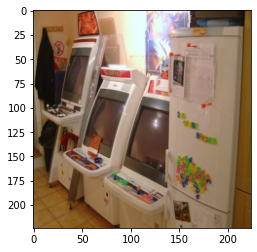

Epoch [5/5], Step [500/2587], Loss: 2.7799
Epoch [5/5], Step [1000/2587], Loss: 2.7323
Epoch [5/5], Step [1500/2587], Loss: 2.1678
Epoch [5/5], Step [2000/2587], Loss: 2.2263
Epoch [5/5], Step [2500/2587], Loss: 2.3840
a group of people standing on top of a


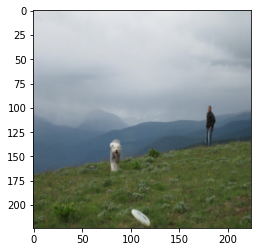

In [14]:
# Train the model
epochs = 5
lr = 3e-4
encoder, decoder = train_and_evaluate(epochs, coco_captioning_tr_data_loader, coco_captioning_val_data_loader, lr)

**I Had limited sources and i could just run for 5 epochs but result is roughly good **

a man sitting on a couch with a laptop


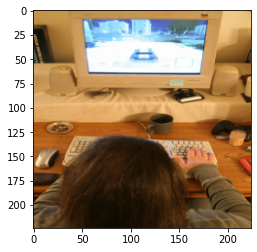

a man holding a cell phone in his


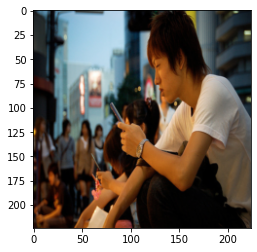

a man is riding a skateboard on a


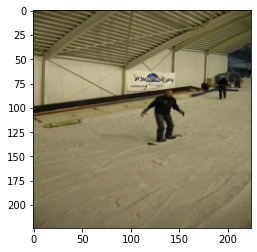

a sandwich with a fork and a cup of


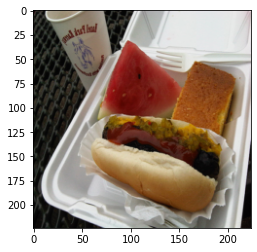

a bathroom with a toilet and a


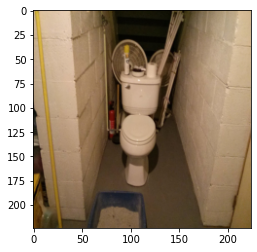

a group of people sitting around a


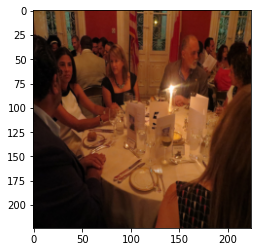

a bunch of bananas are hanging from a


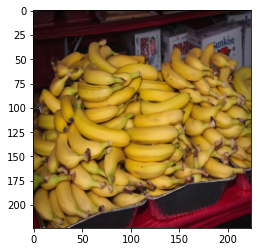

a cow standing in a field of


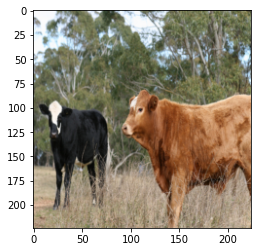

a man is sitting on a bench in a


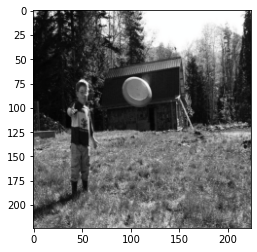

a group of people riding on top of a


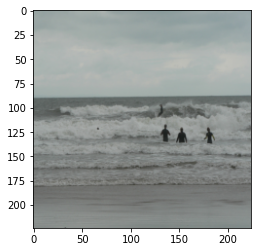

In [21]:
### evalute trained model ###
def generate_caption(encoder, decoder, coco_captioning_val_dataloader,numbers = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for i in range(numbers):
            images, captions = next(iter(coco_captioning_val_dataloader))
            images = images.to(device)
            captions = captions.to(device)
            image = images[0].unsqueeze(0)
            caption = captions[0].unsqueeze(0)
            feature = encoder(image)
            sampled_ids = decoder.sample_generator(feature)
            sampled_ids = sampled_ids[0].cpu().numpy()
            sentence = decoder.vec_to_sentence(sampled_ids)
            image = image.squeeze(0)
            image = image.permute(1, 2, 0).cpu().numpy()
            image = image * np.array((0.229, 0.224, 0.225))+np.array((0.485, 0.456, 0.406)) #unnormalize to orginal
            image = image.clip(0,1)
            plt.imshow(image)
            print(sentence)
            plt.show()
generate_caption(encoder, decoder, coco_captioning_val_data_loader, numbers = 10)